# Correlation Between Heart Rate, Respiration, Blood Pressure and Temperature Series - Lagging Factors?

Text(0.5, 1.0, 'RR Mean Moving Average')

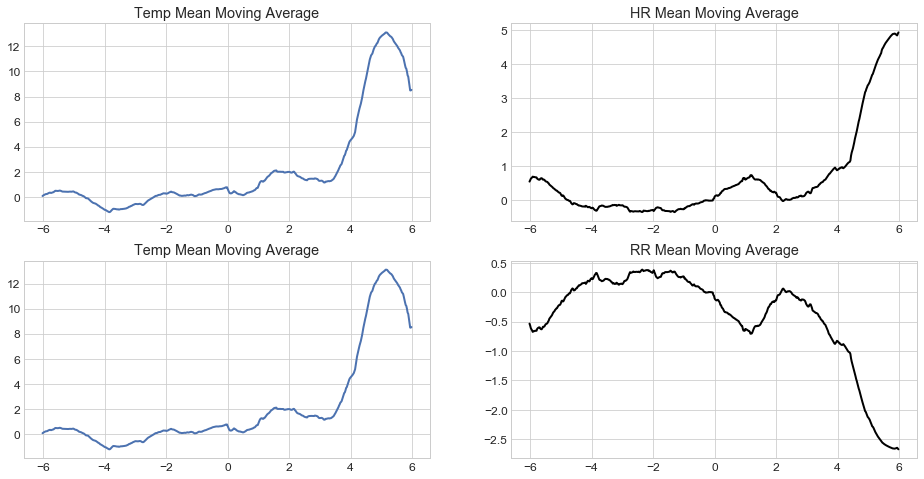

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from get_hierarchical_df import hierarchical_df

plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.max_open_warning': 0})

plt.rcParams.update({'font.size': 12,
                    'xtick.labelsize': 12,
                    'ytick.labelsize': 12,
                    'lines.linewidth': 2,
                    'axes.labelsize': 12,
                    'figure.figsize': (16, 8)})

df = hierarchical_df('transformed_csvs/EBOV-Cyno-Aero-1_transformed.csv')
plt.subplot(2, 2, 1)
plt.plot(df.loc['e1001'].loc['Temp_Mean']['Day'], 
         df.loc['e1001'].loc['Temp_Mean']['Moving_Average'])
plt.title('Temp Mean Moving Average')
plt.subplot(2, 2, 2)
plt.plot(df.loc['e1001'].loc['HR_Mean']['Day'], 
         df.loc['e1001'].loc['HR_Mean']['Moving_Average'],
         color='black')
plt.title('HR Mean Moving Average')

plt.subplot(2, 2, 3)
plt.plot(df.loc['e1001'].loc['Temp_Mean']['Day'], 
         df.loc['e1001'].loc['Temp_Mean']['Moving_Average'])
plt.title('Temp Mean Moving Average')
plt.subplot(2, 2, 4)
plt.plot(df.loc['e1001'].loc['RR_Mean']['Day'], 
         df.loc['e1001'].loc['RR_Mean']['Moving_Average'],
         color='black')
plt.title('RR Mean Moving Average')

## For Respiration and Aortic Blood Pressure

Text(0.5, 1.0, 'AOPA Mean Moving Average')

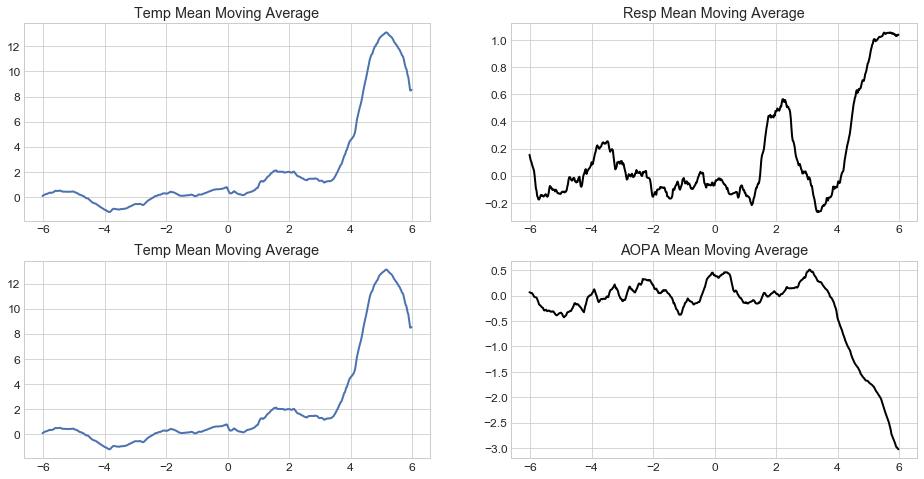

In [10]:
plt.subplot(2, 2, 1)
plt.plot(df.loc['e1001'].loc['Temp_Mean']['Day'], 
         df.loc['e1001'].loc['Temp_Mean']['Moving_Average'])
plt.title('Temp Mean Moving Average')
plt.subplot(2, 2, 2)
plt.plot(df.loc['e1001'].loc['RespMean_Mean']['Day'], 
         df.loc['e1001'].loc['RespMean_Mean']['Moving_Average'],
         color='black')
plt.title('Resp Mean Moving Average')

plt.subplot(2, 2, 3)
plt.plot(df.loc['e1001'].loc['Temp_Mean']['Day'], 
         df.loc['e1001'].loc['Temp_Mean']['Moving_Average'])
plt.title('Temp Mean Moving Average')
plt.subplot(2, 2, 4)
plt.plot(df.loc['e1001'].loc['AOPAMean_Mean']['Day'], 
         df.loc['e1001'].loc['AOPAMean_Mean']['Moving_Average'],
         color='black')
plt.title('AOPA Mean Moving Average')

## Overall Pearson Coefficient - Measure of Global Synchrony

In [13]:
import scipy.stats as stats

temp_mean = df.loc['e1001'].loc['Temp_Mean']['Standard_Dev'][48:]
hr_mean = df.loc['e1001'].loc['HR_Mean']['Standard_Dev'][48:]
rr_mean = df.loc['e1001'].loc['RR_Mean']['Standard_Dev'][48:]
resp_mean = df.loc['e1001'].loc['RespMean_Mean']['Standard_Dev'][48:]
aopa_mean = df.loc['e1001'].loc['AOPAMean_Mean']['Standard_Dev'][48:]

print('Pearson R for Temp_Mean and HR_Mean: ' 
      + str(stats.pearsonr(temp_mean, hr_mean)[0]))
print('Two-tailed p-value: ' 
      + str(stats.pearsonr(temp_mean, hr_mean)[1]))
print()
print('Pearson R for Temp_Mean and RR_Mean: ' 
      + str(stats.pearsonr(temp_mean, rr_mean)[0]))
print('Two-tailed p-value: ' 
      + str(stats.pearsonr(temp_mean, rr_mean)[1]))
print()
print('Pearson R for Temp_Mean and Resp_Mean: ' 
      + str(stats.pearsonr(temp_mean, resp_mean)[0]))
print('Two-tailed p-value: ' 
      + str(stats.pearsonr(temp_mean, resp_mean)[1]))
print()
print('Pearson R for Temp_Mean and AOPA_Mean: ' 
      + str(stats.pearsonr(temp_mean, aopa_mean)[0]))
print('Two-tailed p-value: ' 
      + str(stats.pearsonr(temp_mean, aopa_mean)[1]))

Pearson R for Temp_Mean and HR_Mean: 0.8960545991099076
Two-tailed p-value: 1.3679852096708769e-204

Pearson R for Temp_Mean and RR_Mean: 0.7562502059349111
Two-tailed p-value: 7.804807553338753e-108

Pearson R for Temp_Mean and Resp_Mean: 0.10388257159399225
Two-tailed p-value: 0.012612833039702294

Pearson R for Temp_Mean and AOPA_Mean: -0.2414994574483326
Two-tailed p-value: 4.344639966349417e-09


## Rolling Pearson Coefficient - Local Synchrony

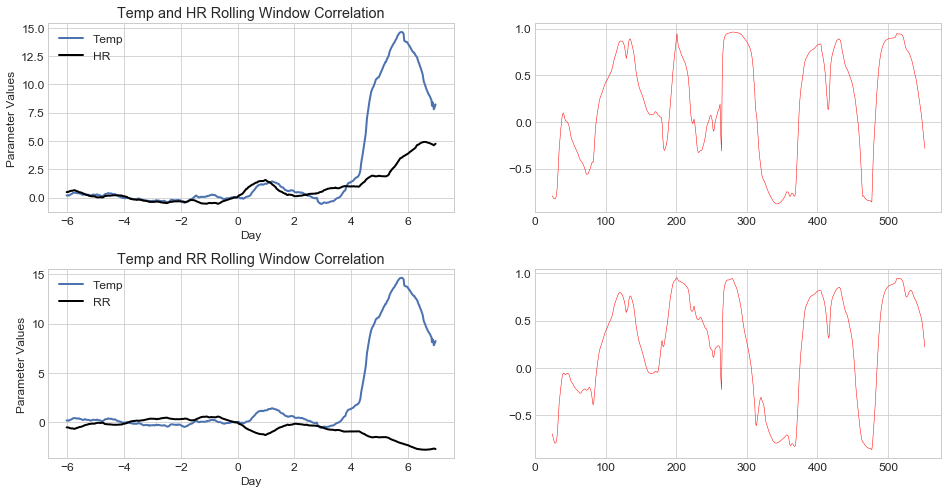

In [14]:
temp_hr = pd.DataFrame({'Temp': temp_mean, 
                        'HR': hr_mean,
                        'RR': rr_mean,
                        'Resp': resp_mean,
                        'AOPA': aopa_mean})

r_window_size = 48 # 1 day
plt.subplots_adjust(hspace=0.3)

plt.subplot(2, 2, 1)
plt.plot(df.loc['e1015'].loc['Temp_Mean']['Day'], 
         df.loc['e1015'].loc['Temp_Mean']['Moving_Average'],
         label='Temp')
plt.plot(df.loc['e1015'].loc['HR_Mean']['Day'], 
         df.loc['e1015'].loc['HR_Mean']['Moving_Average'],
         color='black', label='HR')
plt.title('Temp and HR Rolling Window Correlation') 
plt.xlabel('Day') 
plt.ylabel('Parameter Values')
plt.legend()

plt.subplot(2, 2, 2)
rolling_r_hr = temp_hr['Temp'].rolling(
    window=r_window_size, center=True).corr(temp_hr['HR'])
rolling_r_hr.plot(color='r', lw=0.5)

plt.subplot(2, 2, 3)
plt.plot(df.loc['e1015'].loc['Temp_Mean']['Day'], 
         df.loc['e1015'].loc['Temp_Mean']['Moving_Average'],
         label='Temp')
plt.plot(df.loc['e1015'].loc['RR_Mean']['Day'], 
         df.loc['e1015'].loc['RR_Mean']['Moving_Average'],
         color='black', label='RR')
plt.title('Temp and RR Rolling Window Correlation') 
plt.xlabel('Day') 
plt.ylabel('Parameter Values')
plt.legend()

plt.subplot(2, 2, 4)
rolling_r_rr = temp_hr['Temp'].rolling(
    window=r_window_size, center=True).corr(temp_hr['RR'])
rolling_r_rr.plot(color='r', lw=0.5)

### For Respiration and Aortic Blood Pressure

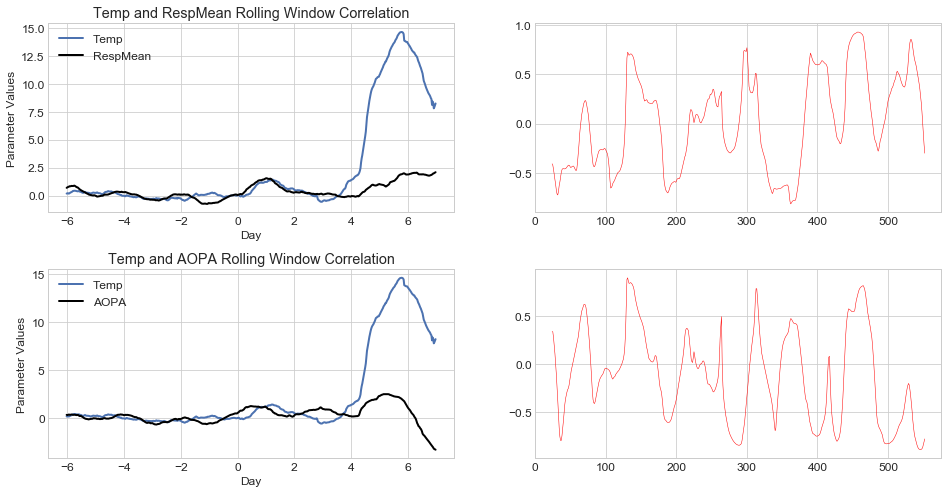

In [21]:
plt.subplots_adjust(hspace=0.3)

plt.subplot(2, 2, 1)
plt.plot(df.loc['e1015'].loc['Temp_Mean']['Day'], 
         df.loc['e1015'].loc['Temp_Mean']['Moving_Average'],
         label='Temp')
plt.plot(df.loc['e1015'].loc['RespMean_Mean']['Day'], 
         df.loc['e1015'].loc['RespMean_Mean']['Moving_Average'],
         color='black', label='RespMean')
plt.title('Temp and RespMean Rolling Window Correlation') 
plt.xlabel('Day') 
plt.ylabel('Parameter Values')
plt.legend()

plt.subplot(2, 2, 2)
rolling_r_resp = temp_hr['Temp'].rolling(
    window=r_window_size, center=True).corr(temp_hr['Resp'])
rolling_r_resp.plot(color='r', lw=0.5)

plt.subplot(2, 2, 3)
plt.plot(df.loc['e1015'].loc['Temp_Mean']['Day'], 
         df.loc['e1015'].loc['Temp_Mean']['Moving_Average'],
         label='Temp')
plt.plot(df.loc['e1015'].loc['AOPAMean_Mean']['Day'], 
         df.loc['e1015'].loc['AOPAMean_Mean']['Moving_Average'],
         color='black', label='AOPA')
plt.title('Temp and AOPA Rolling Window Correlation') 
plt.xlabel('Day') 
plt.ylabel('Parameter Values')
plt.legend()

plt.subplot(2, 2, 4)
rolling_r_aopa = temp_hr['Temp'].rolling(
    window=r_window_size, center=True).corr(temp_hr['AOPA'])
rolling_r_aopa.plot(color='r', lw=0.5)

## Time Lagged Cross Correlation

([<matplotlib.axis.XTick at 0x114f728d0>,
 <a list of 13 Text xticklabel objects>)

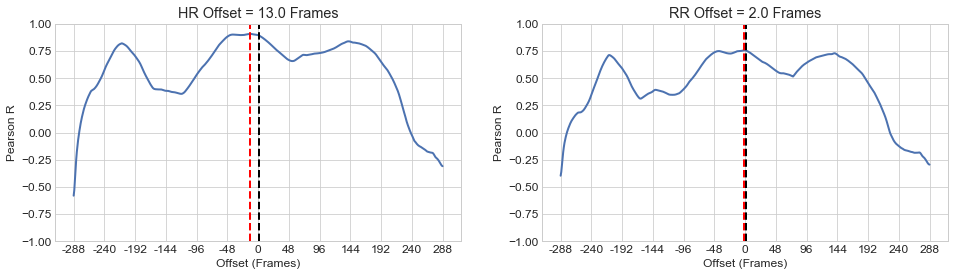

In [31]:
plt.rcParams.update({'figure.figsize': (16, 4)})

def cross_correlation(data_a, data_b, lag=0, wrap=False):
    """
    Lag-N cross correlation
    Shifted data filled with NaNs
    
    Keyword arguments:
    data_a -- pandas Series A
    data_b -- pandas Series B
    lag -- int, default 0
    """
    if wrap:
        shifted_b = data_b.shift(lag)
        shifted_b.iloc[:lag] = data_b.loc[-lag:].values
        return data_a.corr(shifted_b)
    else:
        return data_a.corr(data_b.shift(lag))
    
data_a = pd.Series(temp_mean)
data_b = pd.Series(hr_mean)
data_c = pd.Series(rr_mean)
seconds = np.floor(len(
    np.unique(np.floor(df.loc['e1001'].loc[
        'Temp_Mean']['Day'])) - 1) / 2)
fps = 48
cc = [cross_correlation(
    data_a, data_b, lag) for lag in range(
    -int(seconds * fps), int(seconds * fps + 1))]

cc2 = [cross_correlation(
    data_a, data_c, lag) for lag in range(
    -int(seconds * fps), int(seconds * fps + 1))]

offset = np.ceil(len(cc) / 2) - np.argmax(cc)
offset2 = np.ceil(len(cc2) / 2) - np.argmax(cc2)

plt.subplot(1, 2, 1)
plt.plot(cc)
plt.axvline(np.ceil(len(cc) / 2), color='k', linestyle='--', label='Center')
plt.axvline(np.argmax(cc), color='r', linestyle='--', label='Peak synchrony')
plt.title(f'HR Offset = {offset} Frames')
plt.ylim([-1, 1])
plt.ylabel('Pearson R')
plt.xlabel('Offset (Frames)')
plt.xticks(ticks=range(0, int(plt.xlim()[1]), 48), 
           labels=range(-int(seconds) * 48, int(
               seconds) * 48 + 1, 48))

plt.subplot(1, 2, 2)
plt.plot(cc2)
plt.axvline(np.ceil(len(cc2) / 2), color='k', linestyle='--', label='Center')
plt.axvline(np.argmax(cc2), color='r', linestyle='--', label='Peak synchrony')
plt.title(f'RR Offset = {offset2} Frames')    
plt.ylim([-1, 1])
plt.ylabel('Pearson R')
plt.xlabel('Offset (Frames)')
plt.xticks(ticks=range(0, int(plt.xlim()[1]), 48), 
           labels=range(-int(seconds) * 48, int(
               seconds) * 48 + 1, 48))

### For the Rest of the Subjects
#### Include Respiration and AOPA

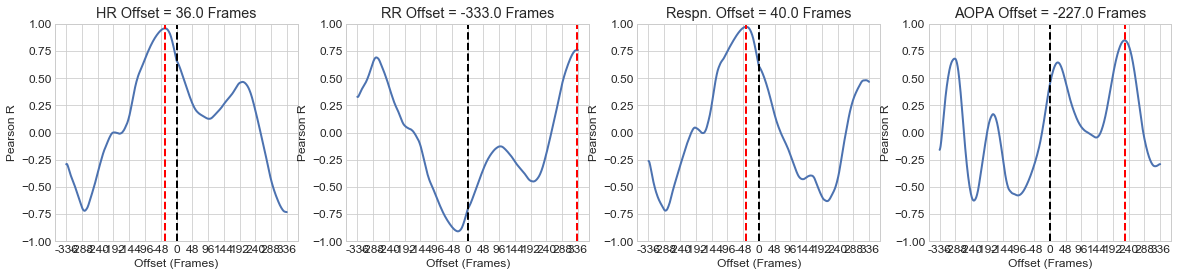

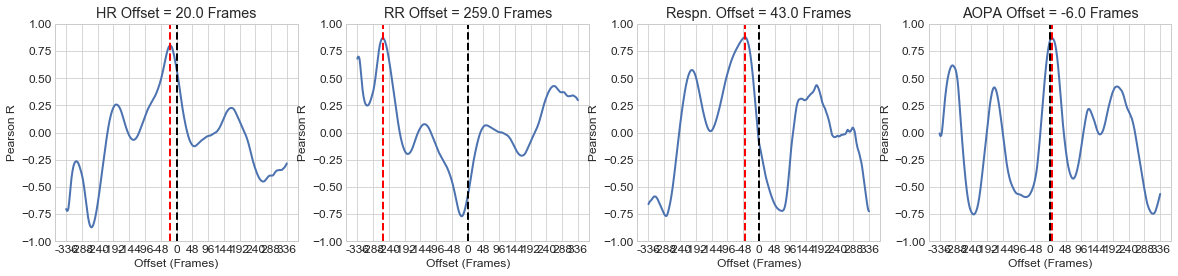

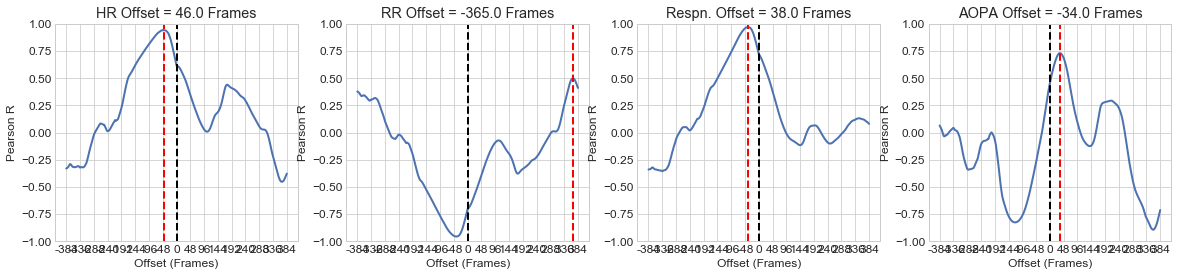

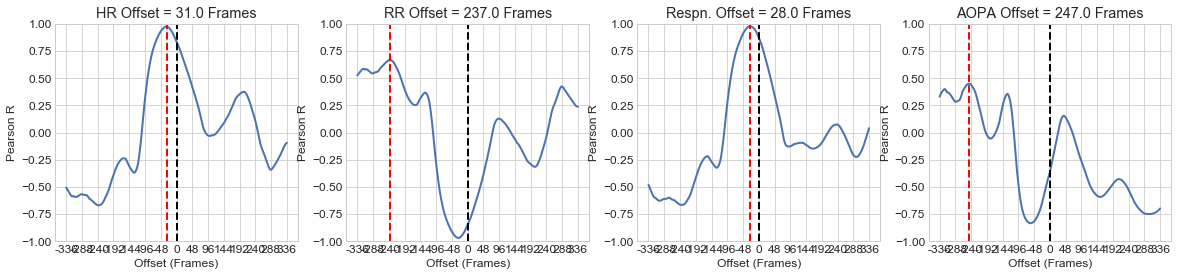

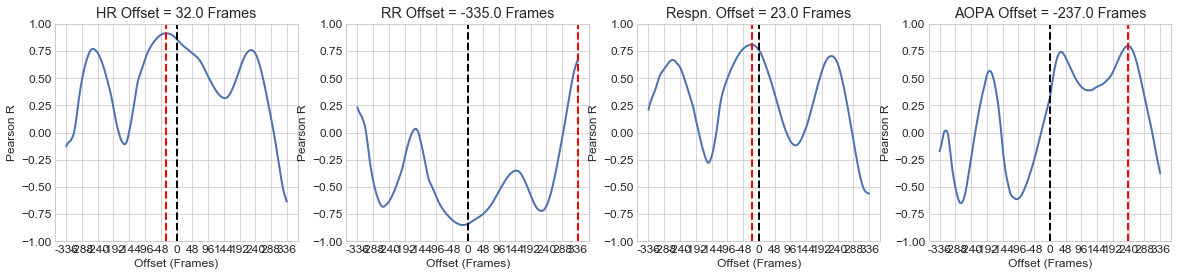

In [35]:
def cross_corr_subj(table, subj, metric):
    df = hierarchical_df(table)
    
    temp_mean = df.loc[subj].loc['Temp_Mean'][metric][48:]
    hr_mean = df.loc[subj].loc['HR_Mean'][metric][48:]
    rr_mean = df.loc[subj].loc['RR_Mean'][metric][48:]
    resp_mean = df.loc[subj].loc['RespMean_Mean'][metric][48:]
    aopa_mean = df.loc[subj].loc['AOPAMean_Mean'][metric][48:]
    
    temp_hr = pd.DataFrame({'Temp': temp_mean, 
                            'HR': hr_mean,
                            'RR': rr_mean,
                            'Resp': resp_mean,
                            'AOPA': aopa_mean})
    
    data_a = pd.Series(temp_mean)
    data_b = pd.Series(hr_mean)
    data_c = pd.Series(rr_mean)
    data_d = pd.Series(resp_mean)
    data_e = pd.Series(aopa_mean)
    
    seconds = np.floor(len(
        np.unique(np.floor(df.loc[subj].loc[
            'Temp_Mean']['Day'])) - 1) / 2)
    
    fps = 48
    
    cc = [cross_correlation(
        data_a, data_b, lag) for lag in range(
        -int(seconds * fps), int(seconds * fps + 1))]
    cc2 = [cross_correlation(
        data_a, data_c, lag) for lag in range(
        -int(seconds * fps), int(seconds * fps + 1))]
    cc3 = [cross_correlation(
        data_a, data_d, lag) for lag in range(
        -int(seconds * fps), int(seconds * fps + 1))]
    cc4 = [cross_correlation(
        data_a, data_e, lag) for lag in range(
        -int(seconds * fps), int(seconds * fps + 1))]
    
    offset = np.ceil(len(cc) / 2) - np.argmax(cc)
    offset2 = np.ceil(len(cc2) / 2) - np.argmax(cc2)
    offset3 = np.ceil(len(cc3) / 2) - np.argmax(cc3)
    offset4 = np.ceil(len(cc4) / 2) - np.argmax(cc4)
    
    fig = plt.figure(figsize=(20,4))
    fig.add_subplot(1, 4, 1)
    plt.plot(cc)
    plt.axvline(np.ceil(len(cc) / 2), color='k', linestyle='--', label='Center')
    plt.axvline(np.argmax(cc), color='r', linestyle='--', label='Peak synchrony')
    plt.title(f'HR Offset = {offset} Frames')
    plt.ylim([-1, 1])
    plt.ylabel('Pearson R')
    plt.xlabel('Offset (Frames)')
    plt.xticks(ticks=range(0, int(plt.xlim()[1]), 48), 
               labels=range(-int(seconds) * 48, int(
                   seconds) * 48 + 1, 48))
    
    fig.add_subplot(1, 4, 2)
    plt.plot(cc2)
    plt.axvline(np.ceil(len(cc2) / 2), color='k', linestyle='--', label='Center')
    plt.axvline(np.argmax(cc2), color='r', linestyle='--', label='Peak synchrony')
    plt.title(f'RR Offset = {offset2} Frames')    
    plt.ylim([-1, 1])
    plt.ylabel('Pearson R')
    plt.xlabel('Offset (Frames)')
    plt.xticks(ticks=range(0, int(plt.xlim()[1]), 48), 
               labels=range(-int(seconds) * 48, int(
                   seconds) * 48 + 1, 48))
    
    fig.add_subplot(1, 4, 3)
    plt.plot(cc3)
    plt.axvline(np.ceil(len(cc3) / 2), color='k', linestyle='--', label='Center')
    plt.axvline(np.argmax(cc3), color='r', linestyle='--', label='Peak synchrony')
    plt.title(f'Respn. Offset = {offset3} Frames')
    plt.ylim([-1, 1])
    plt.ylabel('Pearson R')
    plt.xlabel('Offset (Frames)')
    plt.xticks(ticks=range(0, int(plt.xlim()[1]), 48), 
               labels=range(-int(seconds) * 48, int(
                   seconds) * 48 + 1, 48))
    
    fig.add_subplot(1, 4, 4)
    plt.plot(cc4)
    plt.axvline(np.ceil(len(cc4) / 2), color='k', linestyle='--', label='Center')
    plt.axvline(np.argmax(cc4), color='r', linestyle='--', label='Peak synchrony')
    plt.title(f'AOPA Offset = {offset4} Frames')    
    plt.ylim([-1, 1])
    plt.ylabel('Pearson R')
    plt.xlabel('Offset (Frames)')
    plt.xticks(ticks=range(0, int(plt.xlim()[1]), 48), 
               labels=range(-int(seconds) * 48, int(
                   seconds) * 48 + 1, 48))

for subj in np.unique(df.index.get_level_values(0))[1:]:
    cross_corr_subj('transformed_csvs/EBOV-Cyno-Aero-1_transformed.csv', subj, 'Moving_Average')